## Legacy sci-kit learn code

In [1]:
import warnings

warnings.simplefilter('ignore')

In [2]:
import collections

import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

import pandas as pd

from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals.six import StringIO  
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.svm import LinearSVC

from IPython.display import Image
import pydotplus as pydot

In [3]:
import crosses

In [4]:
annotations = ['AC', 'AF', 'AN', 'Coverage', 'DP', 'HRun', 'HaplotypeScore', 'InbreedingCoeff',
              'MLEAC', 'MQ', 'MQRankSum', 'MQ0',
               'QD', 'QUAL', 'POS', 'FS', 'ReadPosRankSum']

In [5]:
train_raw = crosses.get_train(annotations, normalize=False, scale=False)
train_pre = crosses.get_train(annotations)
train_no_norm = crosses.get_train(annotations, normalize=False)

## Trees

In [6]:
def get_tree(train, annotations):
    tree_clf = tree.DecisionTreeClassifier()
    my_tree = tree_clf.fit(train_pre[annotations].as_matrix(), train['OK'].as_matrix())
    dot_data = StringIO()
    tree.export_graphviz(my_tree, out_file=dot_data, max_depth=4,
                         feature_names=annotations, filled=True)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())  
    img = Image(graph.create_png(prog=['dot', '-Tdot', '-s10', '-Gsize=14,30', '-Gdpi=200']))
    return my_tree, img

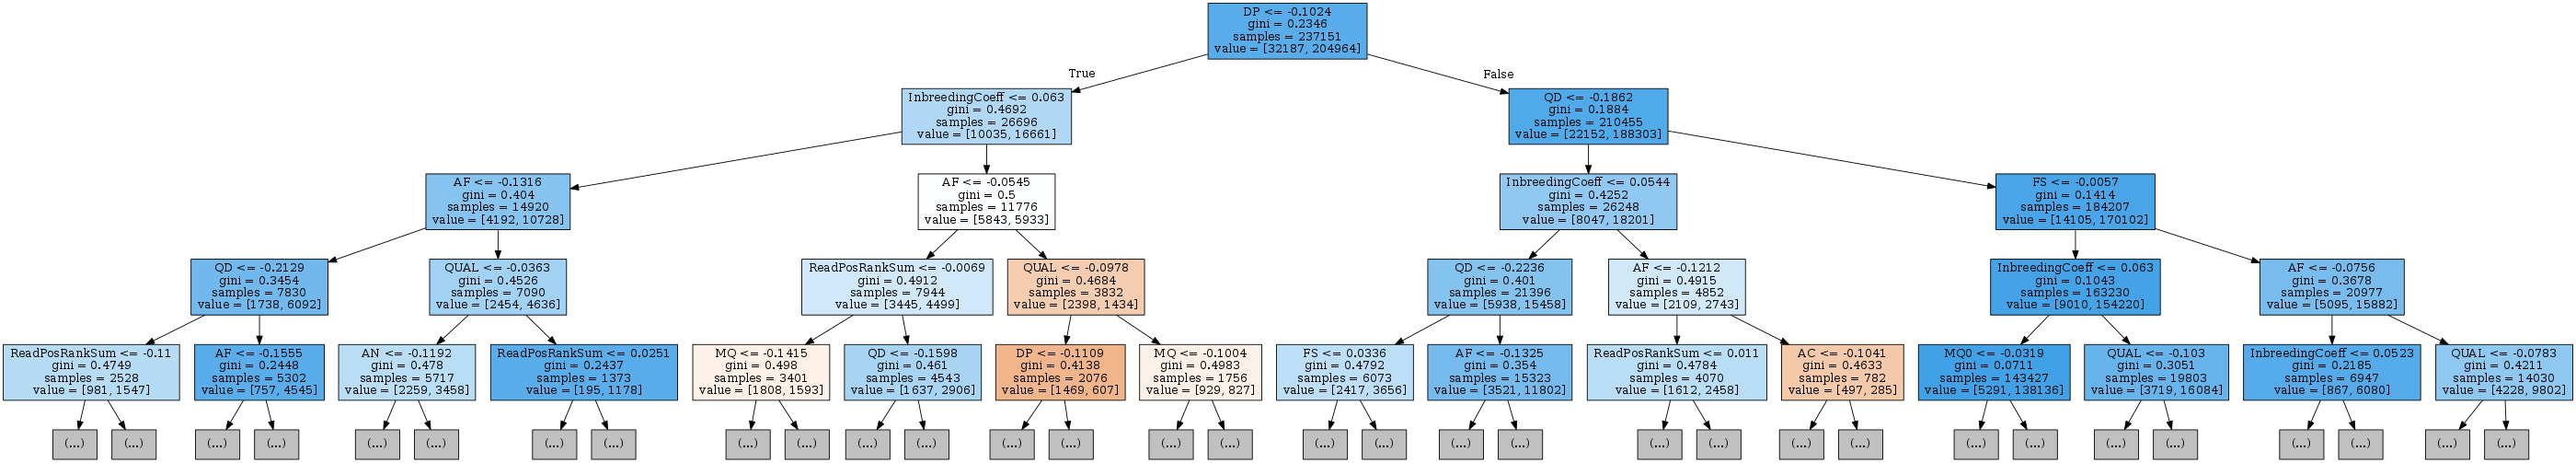

In [7]:
my_tree, img = get_tree(train_pre, annotations)
img

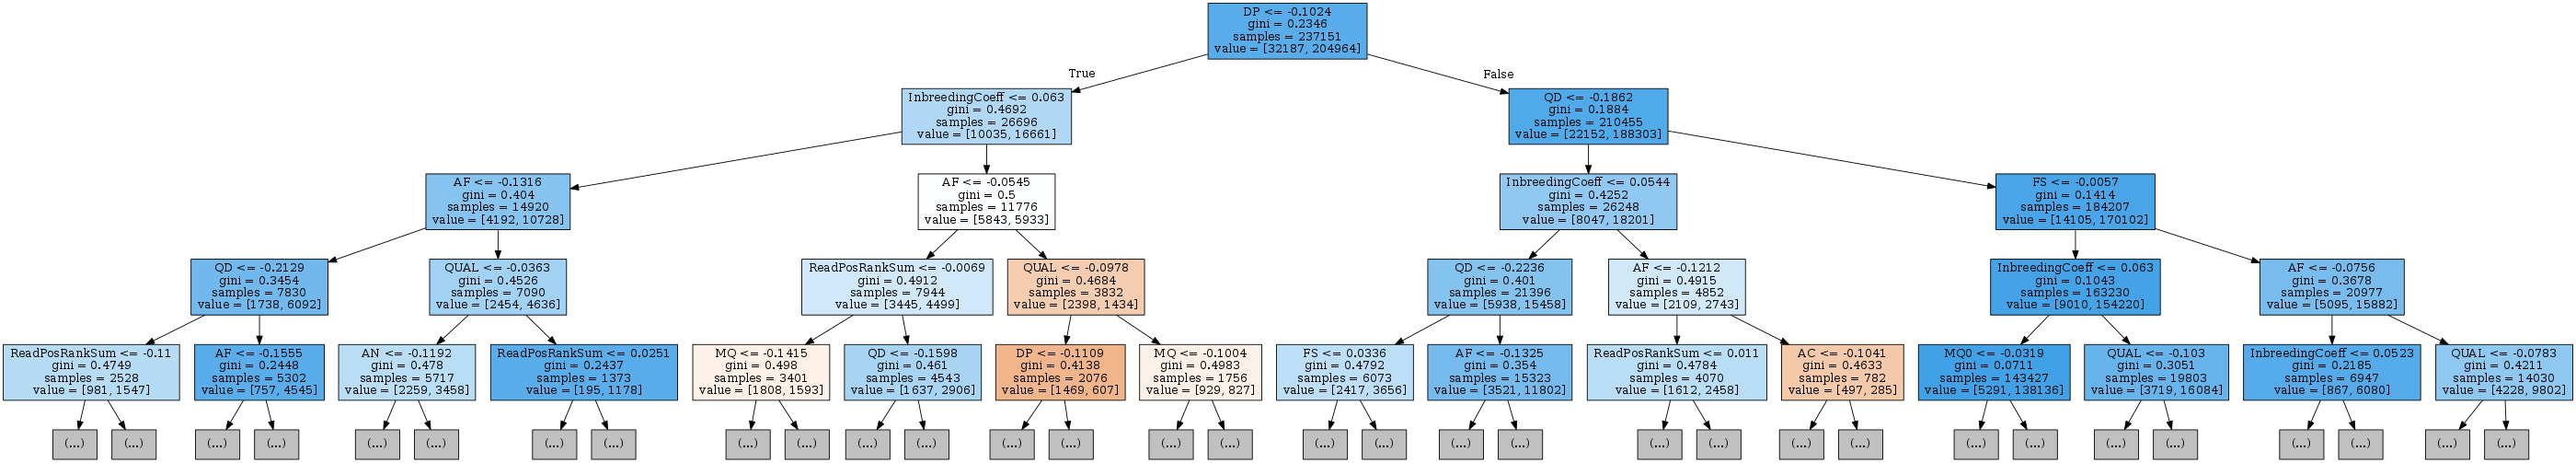

In [8]:
my_tree_no, img = get_tree(train_no_norm, annotations)
img

## Random forest

In [9]:
forest_clf = RandomForestClassifier()
my_forest = forest_clf.fit(train_pre[annotations], train_pre['OK'])

In [10]:
for feat, imp in zip(annotations, my_forest.feature_importances_):
    print(feat, imp)

AC 0.0569433712
AF 0.0558062251874
AN 0.0495732765583
Coverage 0.0585940915827
DP 0.0886417218846
HRun 0.0251384670312
HaplotypeScore 0.0461261426355
InbreedingCoeff 0.0887363694974
MLEAC 0.052584095528
MQ 0.0486280670859
MQRankSum 0.051324020694
MQ0 0.0311933817954
QD 0.0785986925136
QUAL 0.0954075037069
POS 0.045978506547
FS 0.0647322569502
ReadPosRankSum 0.0619938096022


## PCA

In [11]:
ssize = 500
#train_ok = train_pre[train_pre['OK'] == 1].sample(ssize)
#train_err = train_pre[train_pre['OK'] == 0].sample(ssize)
#train_ok = train_raw[train_raw['OK'] == 1].sample(ssize)
#train_err = train_raw[train_raw['OK'] == 0].sample(ssize)
train_ok = train_no_norm[train_no_norm['OK'] == 1].sample(ssize)
train_err = train_no_norm[train_no_norm['OK'] == 0].sample(ssize)
both_train = pd.concat([train_ok, train_err])
both_pca = PCA(n_components=6)
both_pca.fit(both_train[annotations])
both_trans = both_pca.transform(both_train[annotations])
both_trans = pd.DataFrame(both_trans, columns=['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6'], index=both_train.index)
both_trans = pd.concat([both_train, pd.DataFrame(both_trans)], axis=1)
both_trans.shape

(1000, 24)

In [12]:
def plot_pca(trans, annotations, c1, c2):
    #print(trans['OK'])
    fig, axs = plt.subplots(5, 4, squeeze=False, sharex=True, sharey=True, figsize=(18, 18))
    axs[0, 0].scatter(trans[c1].as_matrix(), trans[c2].as_matrix(), edgecolors='face', s=10)
    axs[0, 0].set_title('PCA: Basic')
    
    trans_ok = trans[trans['OK'] == 1]
    axs[0, 1].scatter(trans_ok[c1].as_matrix(), trans_ok[c2].as_matrix(), edgecolors='face', s=10)
    axs[0, 1].set_title('OK')

    trans_err = trans[trans['OK'] == 0]
    axs[0, 2].scatter(trans_err[c1].as_matrix(), trans_err[c2].as_matrix(), edgecolors='face', s=10)
    axs[0, 2].set_title('Error')
    
    row = 0
    col = 3

    for annotation in annotations:
        axs[row, col].scatter(trans[c1].as_matrix(), trans[c2].as_matrix(),
                              edgecolors='face', c=trans[annotation].as_matrix())
        axs[row, col].set_title(annotation)
        if col == 3:
            row += 1
            col = 0
        else:
            col += 1
    return fig

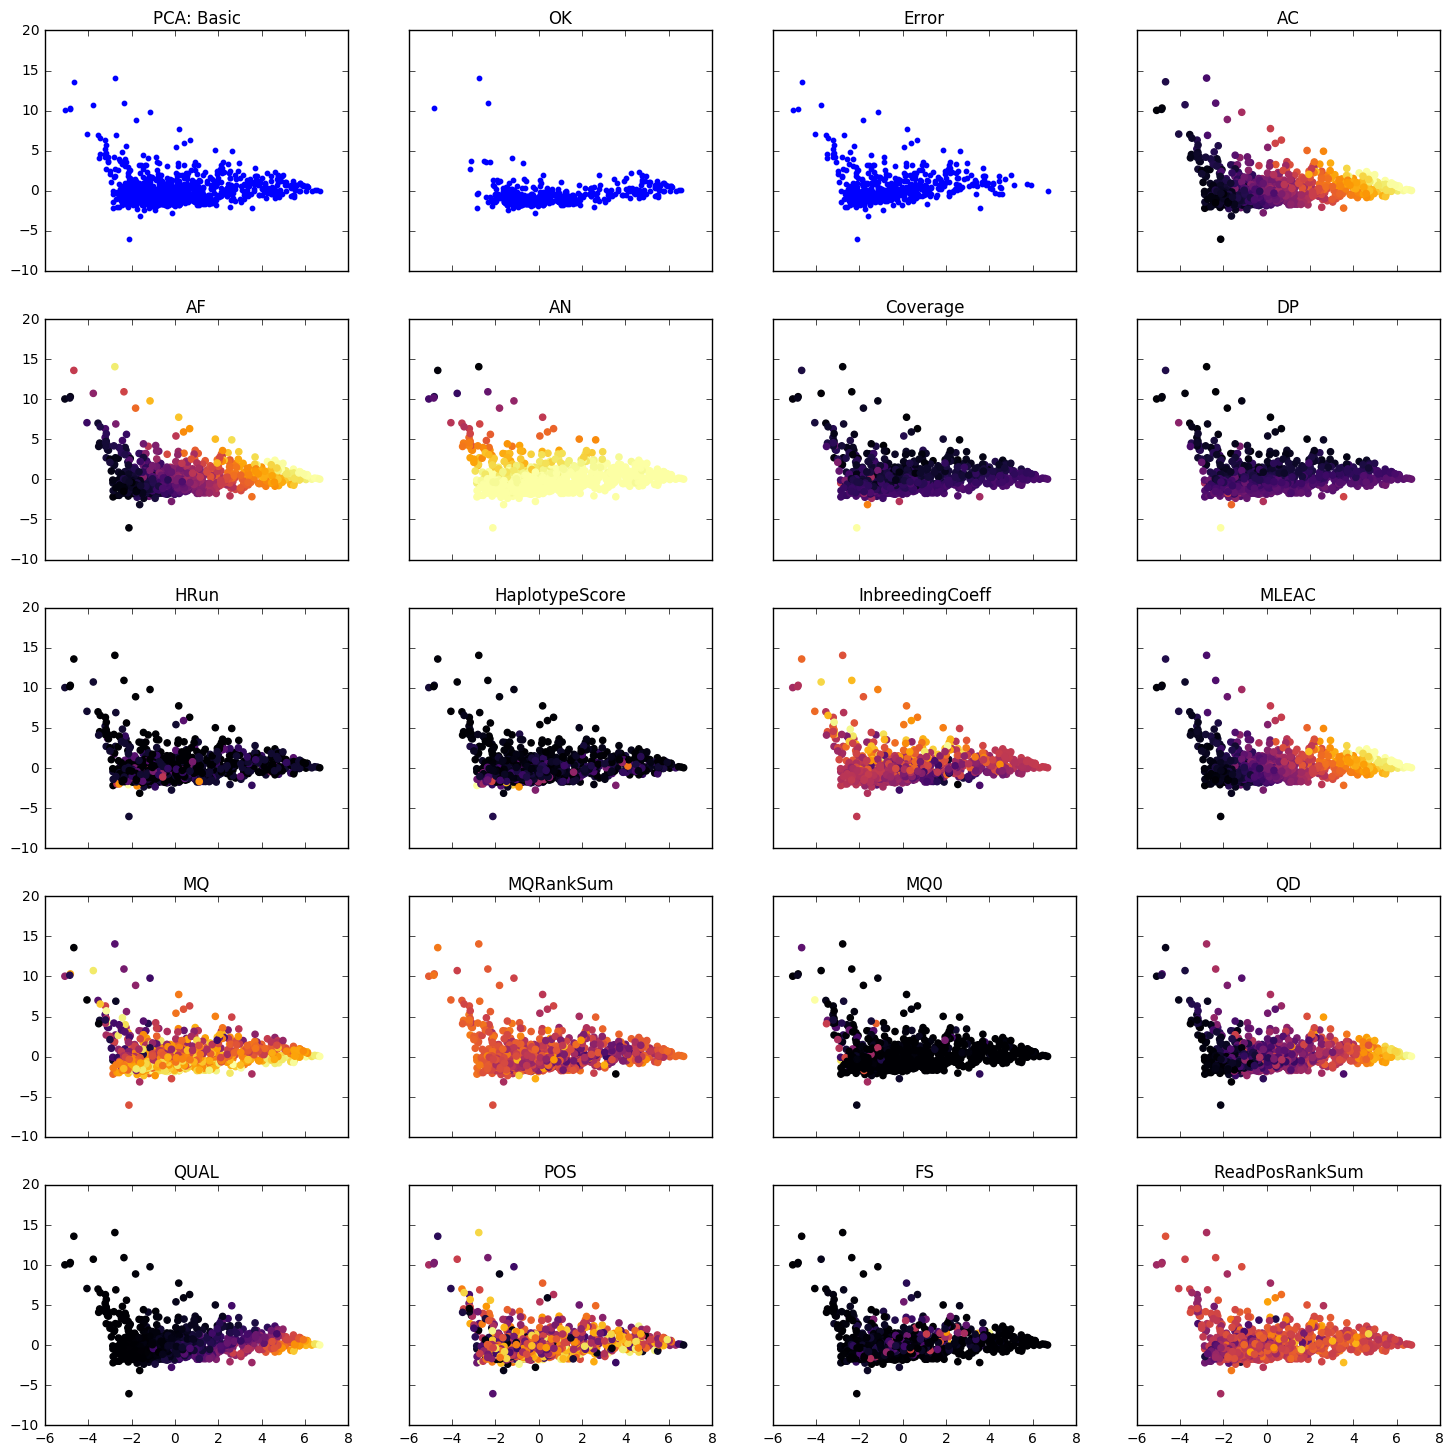

In [13]:
plt.rcParams['image.cmap'] = 'inferno'
plot_pca(both_trans, annotations, 'pc1', 'pc2')
pass

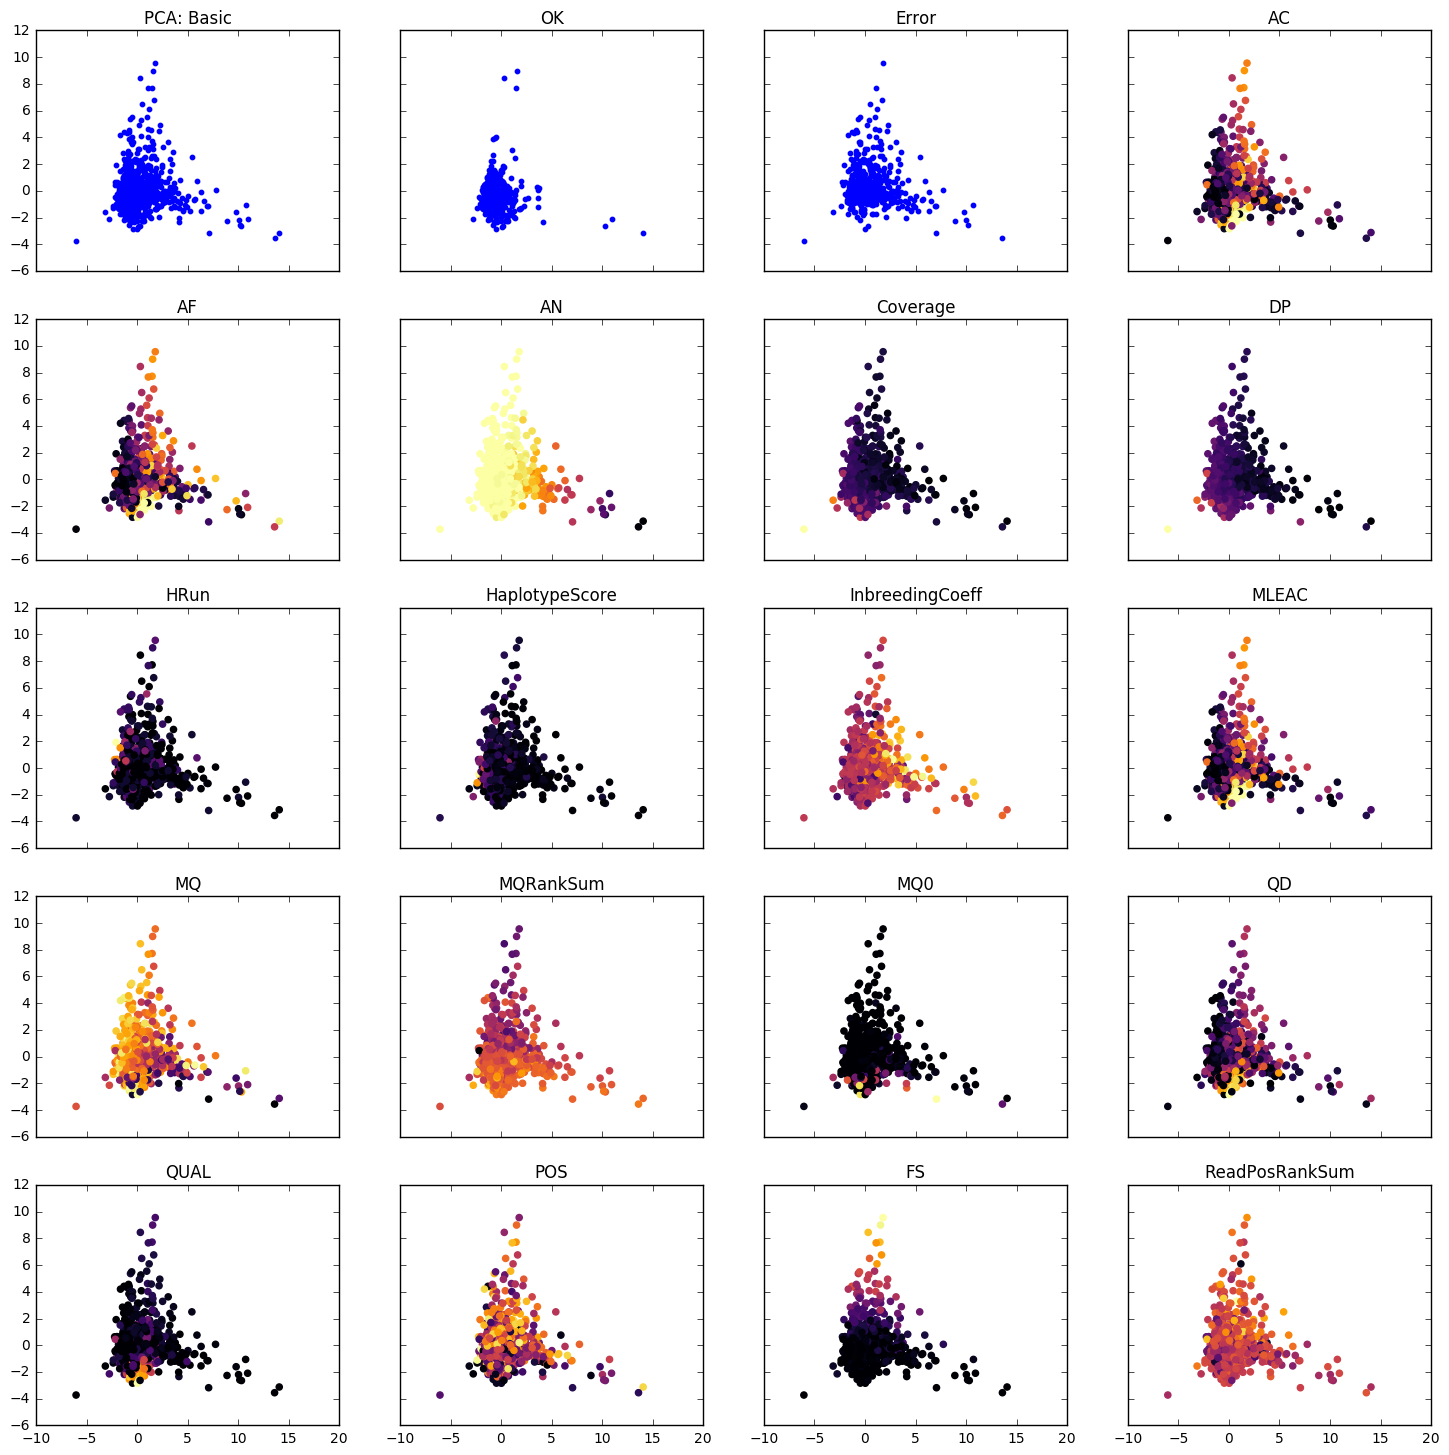

In [14]:
plot_pca(both_trans, annotations, 'pc2', 'pc3')
pass

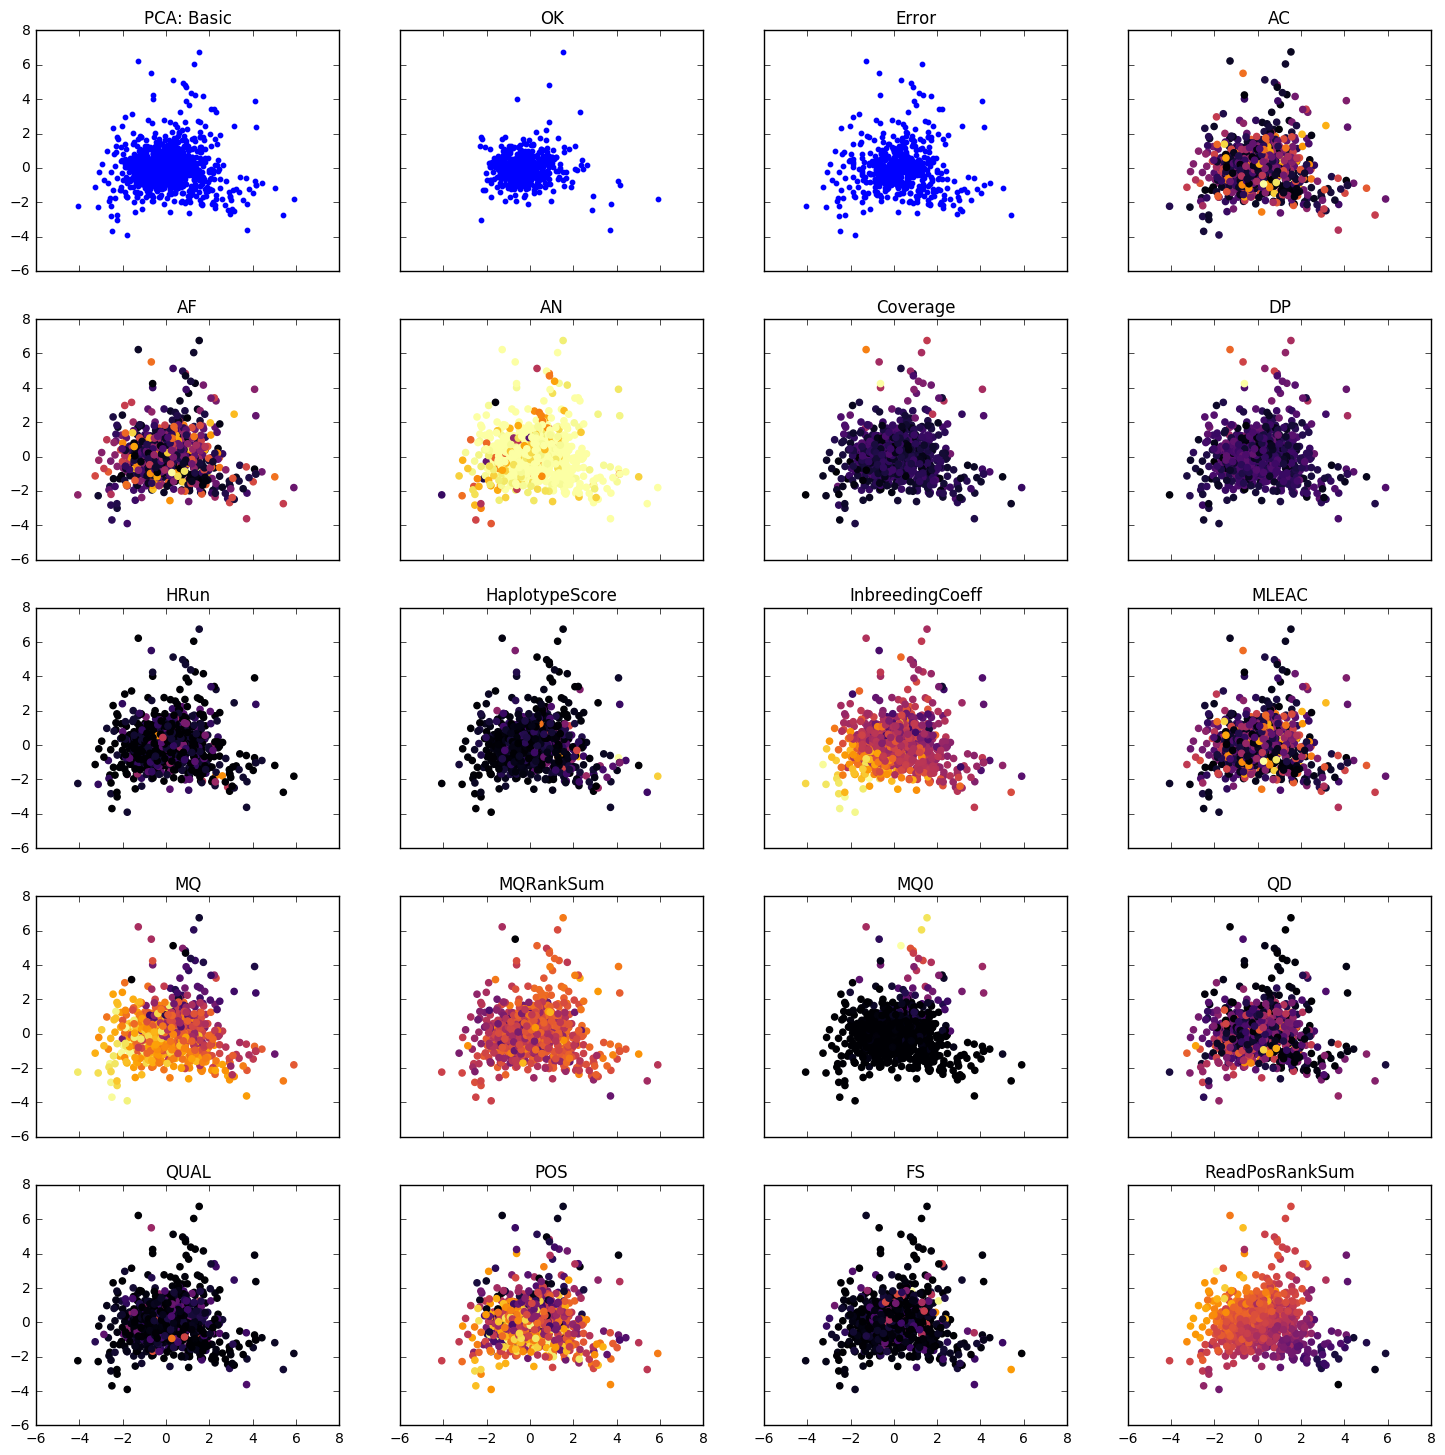

In [15]:
plot_pca(both_trans, annotations, 'pc4', 'pc5')
pass

## Covariance

In [16]:
train_pre[annotations].cov()

,AC,AF,AN,Coverage,DP,HRun,HaplotypeScore,InbreedingCoeff,MLEAC,MQ,MQRankSum,MQ0,QD,QUAL,POS,FS,ReadPosRankSum
AC,1.000004,0.996965,0.651548,0.505662,0.554607,0.431706,0.324946,-0.364678,0.998742,0.626152,-0.391398,0.282709,0.749817,0.708616,-0.479327,0.389387,0.225189
AF,0.996965,1.000004,0.656842,0.507431,0.550197,0.440380,0.328603,-0.352581,0.994696,0.629885,-0.387340,0.289132,0.743508,0.695942,-0.478493,0.384371,0.219081
AN,0.651548,0.656842,1.000004,0.813742,0.868233,0.578845,0.463746,-0.341243,0.631345,0.939908,-0.434354,0.521282,0.636691,0.348356,-0.622931,0.415247,0.026168
Coverage,0.505662,0.507431,0.813742,1.000004,0.922032,0.505375,0.471436,-0.326533,0.490815,0.737878,-0.284546,0.560504,0.472211,0.309398,-0.782363,0.341690,0.033235
DP,0.554607,0.550197,0.868233,0.922032,1.000004,0.500514,0.479597,-0.398906,0.539649,0.785745,-0.382107,0.635299,0.493554,0.355440,-0.756033,0.379556,0.043149
HRun,0.431706,0.440380,0.578845,0.505375,0.500514,1.000004,0.342160,-0.317043,0.422411,0.555705,-0.294310,0.258566,0.357536,0.239649,-0.399821,0.260068,0.104450
HaplotypeScore,0.324946,0.328603,0.463746,0.471436,0.479597,0.342160,1.000004,-0.271926,0.316774,0.452613,-0.239971,0.170051,0.241394,0.202155,-0.343848,0.254092,-0.034542
InbreedingCoeff,-0.364678,-0.352581,-0.341243,-0.326533,-0.398906,-0.317043,-0.271926,1.000004,-0.377193,-0.366250,0.346121,-0.082290,-0.201929,-0.314377,0.308117,-0.239160,-0.282066
MLEAC,0.998742,0.994696,0.631345,0.490815,0.539649,0.422411,0.316774,-0.377193,1.000004,0.611706,-0.378111,0.263634,0.752506,0.715558,-0.471031,0.375625,0.232986
MQ,0.626152,0.629885,0.939908,0.737878,0.785745,0.555705,0.452613,-0.366250,0.611706,1.000004,-0.432935,0.264991,0.725710,0.402037,-0.543875,0.385150,0.034672


## Re-analyze

In [17]:
reduced_annotations = ['DP', 'HRun', 'MQRankSum', 'MQ0', 'QD', 'FS', 'ReadPosRankSum']

In [18]:
train_reduced = crosses.get_train(reduced_annotations)

In [19]:
train_reduced_no_norm = crosses.get_train(reduced_annotations, normalize=False)

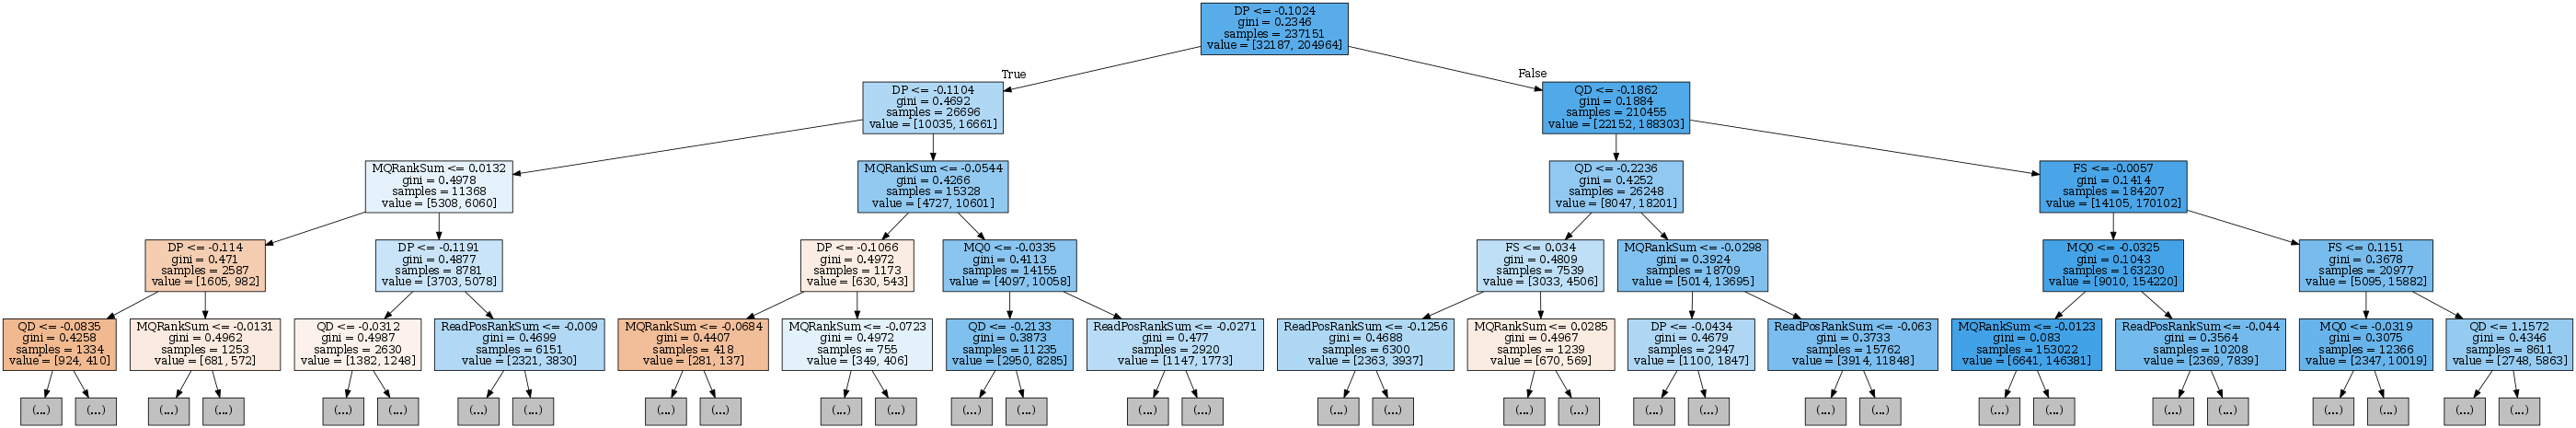

In [20]:
tree_reduced, img_reduced = get_tree(train_reduced, reduced_annotations)
img_reduced

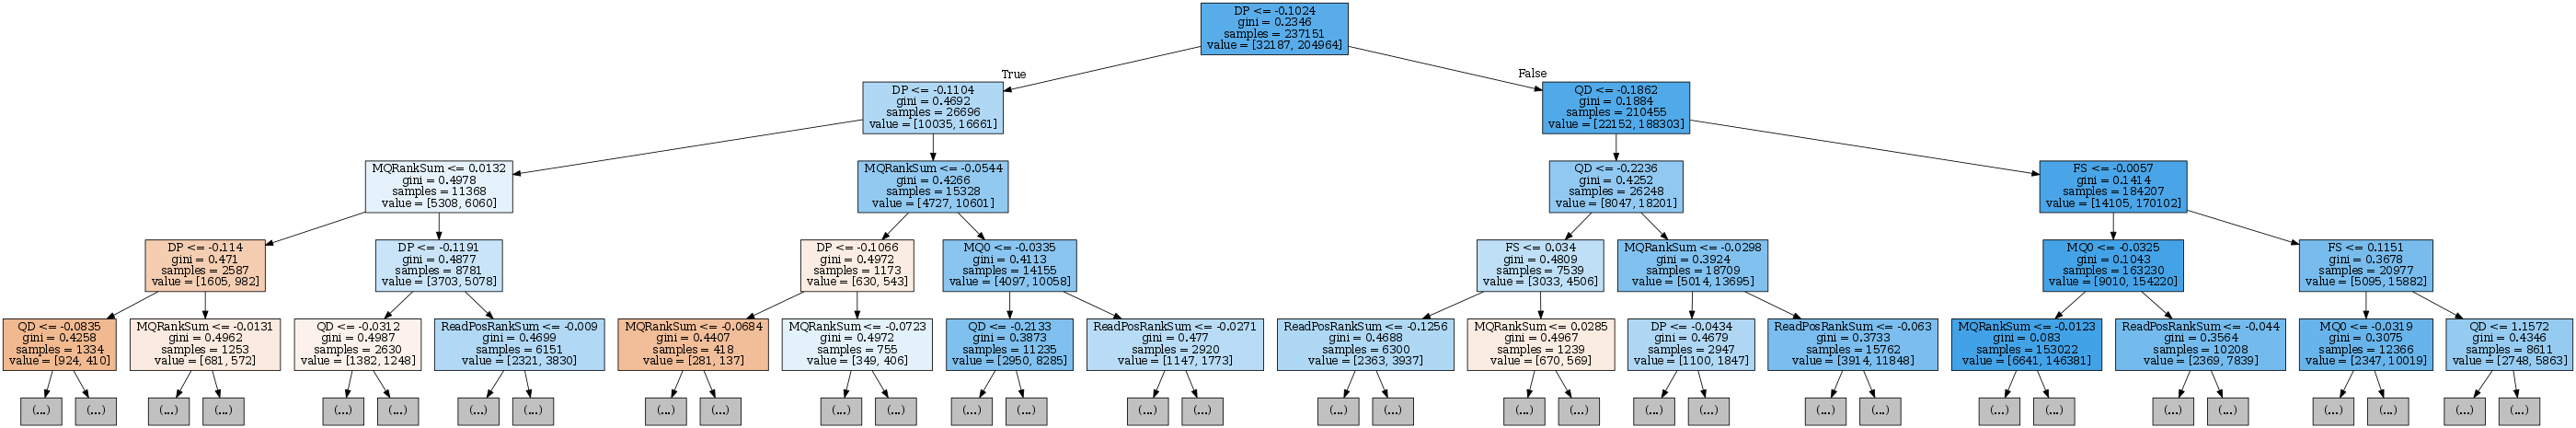

In [21]:
tree_reduced_no, img_reduced = get_tree(train_reduced_no_norm, reduced_annotations)
img_reduced

In [22]:
forest_reduced_clf = RandomForestClassifier()
forest_reduced = forest_clf.fit(train_reduced[reduced_annotations], train_reduced['OK'])

In [23]:
for feat, imp in zip(reduced_annotations, forest_reduced.feature_importances_):
    print(feat, imp)

DP 0.175246405653
HRun 0.0760957820351
MQRankSum 0.166237521991
MQ0 0.0668342780793
QD 0.178504612006
FS 0.174666556691
ReadPosRankSum 0.162414843545


In [24]:
train_reduced[reduced_annotations].cov()

,DP,HRun,MQRankSum,MQ0,QD,FS,ReadPosRankSum
DP,1.000004,-0.077542,0.098273,-0.669664,-0.053835,-0.582672,-0.032682
HRun,-0.077542,1.000004,-0.037639,0.039570,0.238829,0.094338,-0.008480
MQRankSum,0.098273,-0.037639,1.000004,0.081097,-0.033285,-0.343969,-0.158613
MQ0,-0.669664,0.039570,0.081097,1.000004,-0.061556,-0.008972,-0.028979
QD,-0.053835,0.238829,-0.033285,-0.061556,1.000004,0.084077,0.096603
FS,-0.582672,0.094338,-0.343969,-0.008972,0.084077,1.000004,0.090007
ReadPosRankSum,-0.032682,-0.008480,-0.158613,-0.028979,0.096603,0.090007,1.000004


In [25]:
ssize = 10000
train_reduced_ok = train_reduced[train_reduced['OK'] == 1].sample(ssize)
train_reduced_err = train_reduced[train_reduced['OK'] == 0].sample(ssize)
both_train_reduced = pd.concat([train_reduced_ok, train_reduced_err])
both_pca_reduced = PCA(n_components=4)
both_pca_reduced.fit(both_train_reduced[reduced_annotations])
both_trans_reduced = both_pca_reduced.transform(both_train_reduced[reduced_annotations])
both_trans_reduced = pd.DataFrame(both_trans_reduced, columns=['pc1', 'pc2', 'pc3', 'pc4'], index=both_train_reduced.index)
both_trans_reduced = pd.concat([both_train_reduced, pd.DataFrame(both_trans_reduced)], axis=1)
both_trans_reduced.shape

(20000, 12)

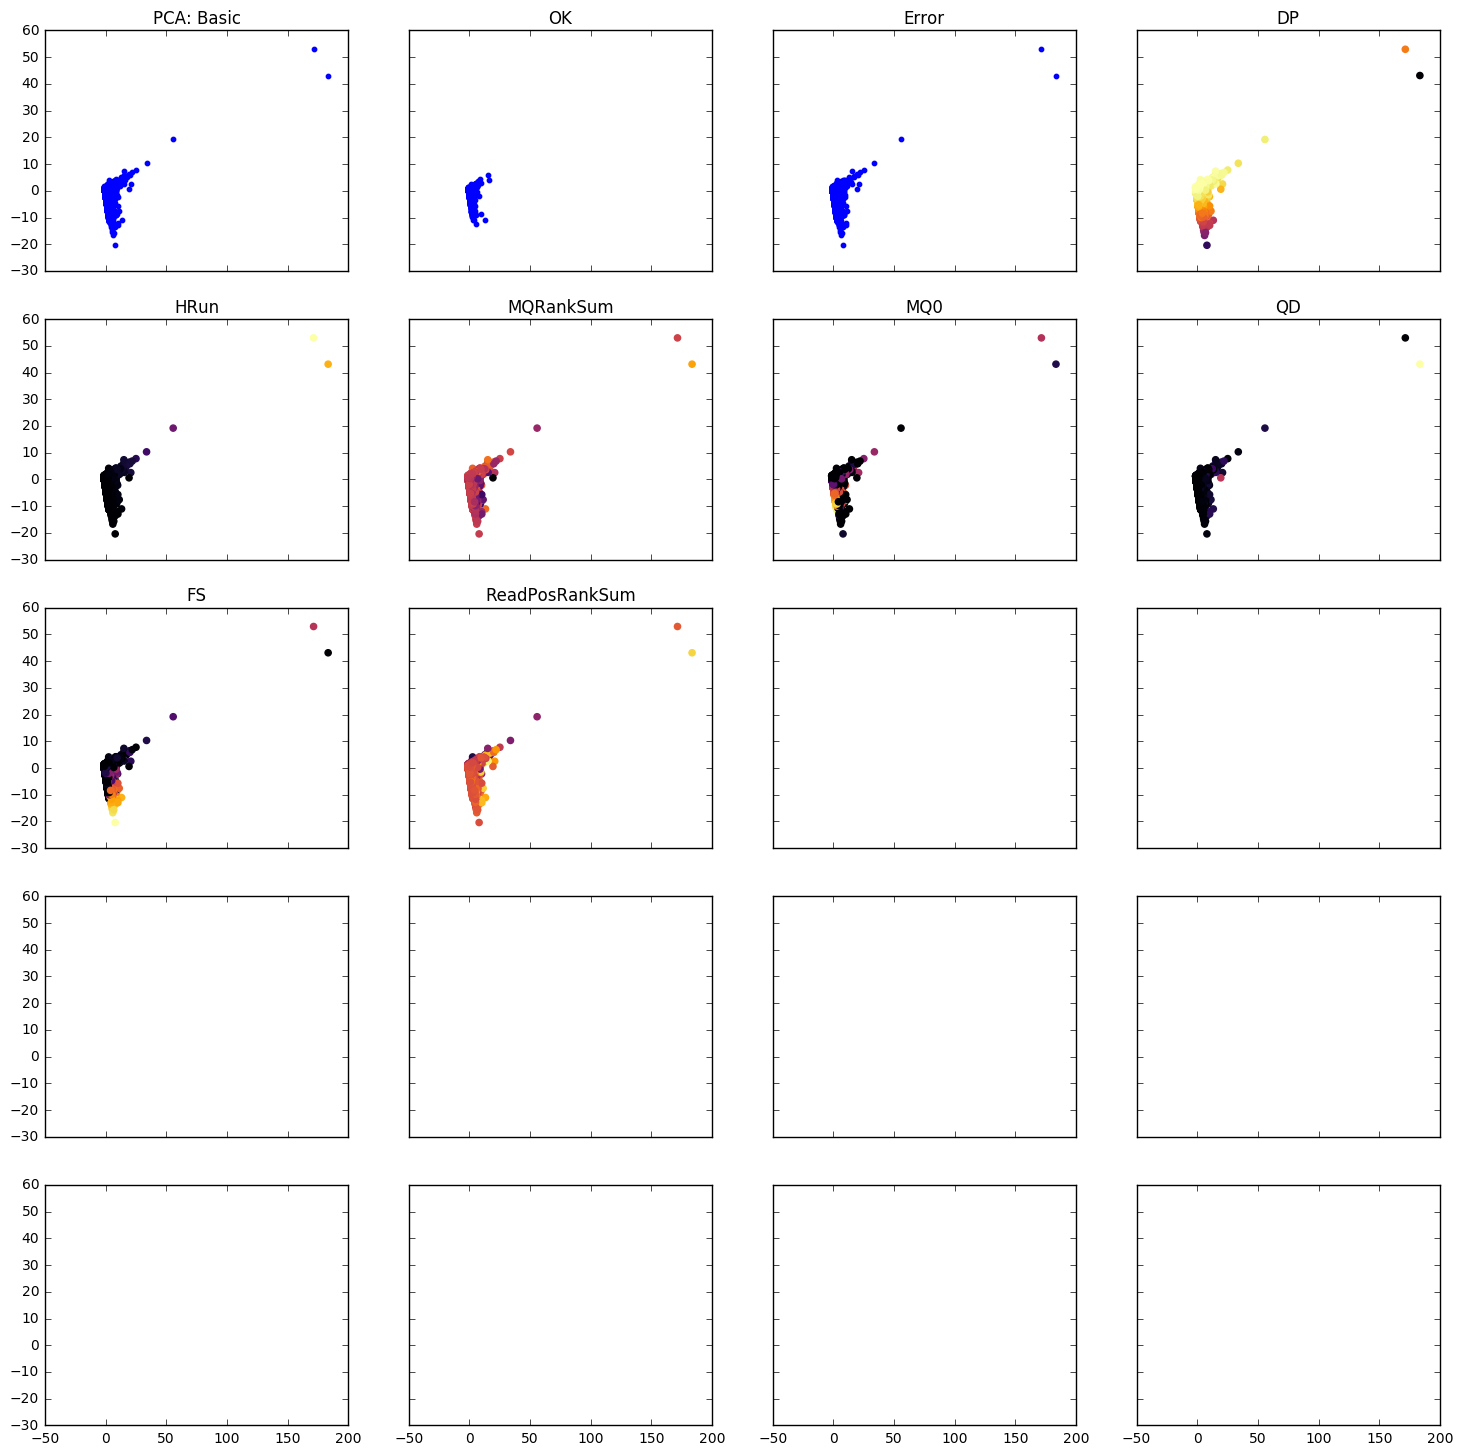

In [26]:
plot_pca(both_trans_reduced, reduced_annotations, 'pc1', 'pc2')
pass

## Regressor

In [27]:
both_train_reduced_again = pd.concat([train_reduced_ok, train_reduced_err])
train_reduced_with_scale, scaler = crosses.get_train(reduced_annotations, True)

In [28]:
ssize = 10000

train_reduced_ok_sc = train_reduced_with_scale[train_reduced_with_scale['OK'] == 1].sample(ssize)
train_reduced_err_sc = train_reduced_with_scale[train_reduced_with_scale['OK'] == 0].sample(ssize)

both_train_reduced_sc = pd.concat([train_reduced_ok_sc, train_reduced_err_sc])

In [29]:
clf = linear_model.LogisticRegression()
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(n_neighbors=5)
clf = linear_model.SGDClassifier()
from sklearn import ensemble
clf = ensemble.RandomForestClassifier(n_estimators=10, max_depth=10)
clf.fit(both_train_reduced_sc[reduced_annotations], np.ravel(both_train_reduced_sc['OK']))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [30]:
clf.score(both_train_reduced_sc[reduced_annotations], np.ravel(both_train_reduced_sc['OK']))


0.80820000000000003

In [31]:
#both_train_reduced_sc[reduced_annotations].columns, np.transpose(clf.coef_)

In [36]:
my_parents = crosses.parents[0]
ofs_mo = crosses.samples.index(my_parents[0])
ofs_fa = crosses.samples.index(my_parents[1])
ofs_start, ofs_end = crosses.get_offspring_range(my_parents, crosses.samples)

annot_dict = {}
for annotation in reduced_annotations:
    annot_dict[annotation] = crosses.store_3L.get_node('/3L/variants/%s' % annotation).read()


i = 0
test_results = collections.OrderedDict()
all_entries = []
all_Y = []
for i, pos in enumerate(crosses.poses):
    genotype = crosses.genotypes[i]
    mo_alleles = genotype[ofs_mo,:]
    fa_alleles = genotype[ofs_fa,:]
    ofs_alleles = genotype[ofs_start:ofs_end,:]
    my_entry = []
    for annotation in reduced_annotations:
        my_entry.append(annot_dict[annotation][i])
    errors = crosses.compute_medelian_errors([mo_alleles, fa_alleles], ofs_alleles)
    if errors is None:
        cnt = None
    else:
        total, cnt, cnt_mo, cnt_fa = errors
        all_Y.append(0 if cnt > 0 else 1)
        all_entries.append(my_entry)
    i += 1
    if i == 1000:
        break

ready_data = scaler.transform(preprocessing.normalize(all_entries))
prediction = clf.predict(ready_data)
test_results[pos] = cnt, prediction[0]
del annot_dict

In [37]:
clf.score(ready_data, all_Y)

0.50407608695652173

In [38]:
num_errors = 0
for cnt, prediction in zip(all_Y, all_entries):
    #print(cnt, prediction)
    if cnt > 0 and prediction[0] == 0:
        num_errors += 1 